In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [88]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc , silhouette_samples , silhouette_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import joblib
from functools import *
from sklearn.feature_selection import SelectFromModel
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chisquare
%matplotlib inline

In [68]:
df_ggsheet = pd.read_excel("/content/drive/MyDrive/BADS7105_CRM_ANALYTICS_AND_INTELLIGENT/HW_09_AB Testing/BADS7105_CRM_AB_TESTING (การตอบกลับ) (1).xlsx")

In [69]:
df_ggsheet.columns = ["Time","Year_Interval","Team_Supporter","Team_Hater"]


In [70]:
ls_sel_tm = ['Arsenal',
 'Chelsea',
 'Liverpool',
 'Manchester City',
 'Manchester United',
 'Spurs']

In [71]:
df_ggsheet = df_ggsheet[(df_ggsheet["Team_Supporter"].isin(ls_sel_tm)) & (df_ggsheet["Team_Hater"].isin(ls_sel_tm))].reset_index().drop("index",axis=1)

In [72]:
df_ggsheet

,Time,Year_Interval,Team_Supporter,Team_Hater
0,2021-05-01 23:10:46.895,1990-1999,Arsenal,Spurs
1,2021-05-01 23:10:55.895,1990-1999,Chelsea,Manchester United
2,2021-05-01 23:11:48.714,1990-1999,Manchester United,Liverpool
3,2021-05-01 23:12:08.657,1980-1989,Arsenal,Manchester United
4,2021-05-01 23:13:29.379,1990-1999,Liverpool,Manchester United
...,...,...,...,...
171,2021-05-02 18:29:38.348,1990-1999,Liverpool,Manchester United
172,2021-05-02 21:04:09.818,1980-1989,Liverpool,Manchester United
173,2021-05-02 21:17:43.324,1990-1999,Chelsea,Liverpool
174,2021-05-02 21:30:38.881,1990-1999,Spurs,Arsenal


In [73]:
df_ggsheet.groupby("Team_Supporter").size()

Team_Supporter
Arsenal              16
Chelsea              34
Liverpool            30
Manchester City      14
Manchester United    73
Spurs                 9
dtype: int64

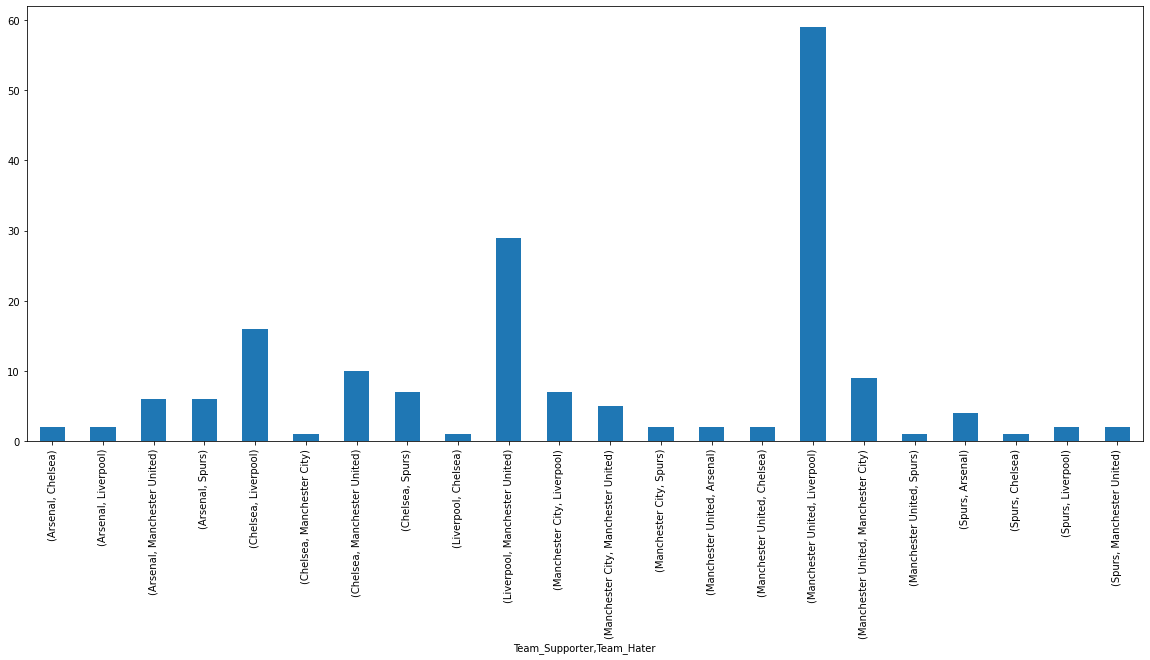

In [99]:
plt.figure(figsize=(20,8))
groups = df_ggsheet.groupby(['Team_Supporter','Team_Hater']).size()
groups.plot.bar()
plt.savefig("/content/drive/MyDrive/BADS7105_CRM_ANALYTICS_AND_INTELLIGENT/HW_09_AB Testing/Overall ratio hater.png",format='png',dpi=150)

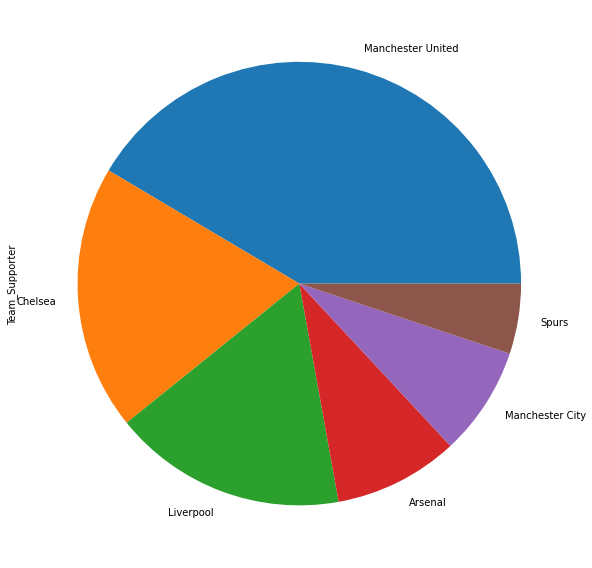

In [100]:
plt.figure(figsize=(20,8))
df_ggsheet['Team_Supporter'].value_counts().plot.pie()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/BADS7105_CRM_ANALYTICS_AND_INTELLIGENT/HW_09_AB Testing/Overall ratio support.png",format='png',dpi=150)

In [76]:
df_agg_data = df_ggsheet[["Team_Supporter","Year_Interval","Team_Hater"]].groupby(["Year_Interval","Team_Supporter","Team_Hater"]).size().reset_index().rename({0:"Count"},axis=1)
df_agg_data.pivot_table(index="Team_Supporter",columns="Team_Hater",aggfunc="sum").fillna(0).reset_index()

Team_Supporter   Count  ...                        
Team_Hater                    Arsenal  ... Manchester United Spurs
0                     Arsenal     0.0  ...               6.0   6.0
1                     Chelsea     0.0  ...              10.0   7.0
2                   Liverpool     0.0  ...              29.0   0.0
3             Manchester City     0.0  ...               5.0   2.0
4           Manchester United     2.0  ...               0.0   1.0
5                       Spurs     4.0  ...               2.0   0.0

[6 rows x 7 columns]

In [148]:
df_agg_data_adj = df_agg_data.pivot_table(index="Team_Supporter",columns="Team_Hater",aggfunc=np.sum).fillna(0).reset_index()
df_agg_data_adj.columns = df_agg_data_adj.columns.droplevel()
df_agg_data_adj = df_agg_data_adj.rename({"":"Team_Supporter"},axis=1)

------------ ทดสอบสัดส่วนความของต่างของคนที่ชอบเชียร์ทีม -> Arsenal ------------

H0 : แฟนบอลที่เชียร์สโมสร Arsenal มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 ไม่แตกต่างกัน
H1 : แฟนบอลที่เชียร์สโมสร Arsenal มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 แตกต่างกัน
ที่ระดับนัยสำคัญ 0.05

แฟนบอลสโมสร Arsenal มีความไม่ชอบต่อสโมสรใน Big6 แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = 0.015609416100266893

>>>>>>>>> ทีมที่แฟนบอลสโมสร Arsenal ไม่ชอบมากที่สุดคือ Manchester United <<<<<<<<<<



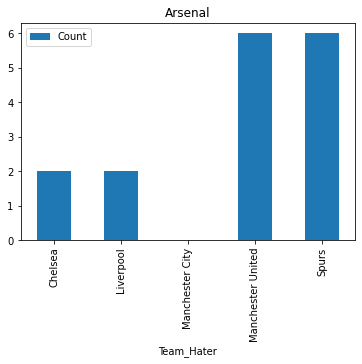

In [192]:
i = ls_sel_tm[0]
print("------------ ทดสอบสัดส่วนความของต่างของคนที่ชอบเชียร์ทีม ->" , i , "------------")
print()
print(f'H0 : แฟนบอลที่เชียร์สโมสร {i} มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 ไม่แตกต่างกัน')
print(f'H1 : แฟนบอลที่เชียร์สโมสร {i} มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 แตกต่างกัน')
print("ที่ระดับนัยสำคัญ 0.05")
print()
data_sel = df_agg_data_adj[df_agg_data_adj["Team_Supporter"] == i]
ls_sell_new = [ij for ij in ls_sel_tm if ij != i]
ls_data_sel = data_sel[data_sel["Team_Supporter"] == i].values[0][1:]
ttsrt = data_sel[data_sel["Team_Supporter"]==i][ls_sell_new].T
ttsrt.columns = ["Count"]
ttsrt = ttsrt.sort_values(by=["Count"],ascending=False)
# ck_len = 5-len(ls_data_sel)
# if len(ls_data_sel) < 5 :
#   for kk in range(ck_len) :
#     ls_data_sel.append(0)
result = chisquare(ls_data_sel)
if result[1] > 0.05 :
  print(f'แฟนบอลสโมสร {i} มีความไม่ชอบต่อสโมสรใน Big6 ไม่แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = {result[1]}')
else :
  print(f'แฟนบอลสโมสร {i} มีความไม่ชอบต่อสโมสรใน Big6 แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = {result[1]}')
  print()
  print(f'>>>>>>>>> ทีมที่แฟนบอลสโมสร {i} ไม่ชอบมากที่สุดคือ {ttsrt.index[0]} <<<<<<<<<<')
print()
toplot = data_sel[ls_sell_new].T.reset_index()
toplot.columns = ["Team_Hater" , "Count"]
toplot.plot.bar(x="Team_Hater",y="Count")
plt.title(i)
plt.savefig(f'/content/drive/MyDrive/BADS7105_CRM_ANALYTICS_AND_INTELLIGENT/HW_09_AB Testing/Overall hate by {i}.png',format='png',dpi=150)
# data_sel.plot.bar(x="Team_Hater",y="Count")

------------ ทดสอบสัดส่วนความของต่างของคนที่ชอบเชียร์ทีม -> Chelsea ------------

H0 : แฟนบอลที่เชียร์สโมสร Chelsea มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 ไม่แตกต่างกัน
H1 : แฟนบอลที่เชียร์สโมสร Chelsea มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 แตกต่างกัน
ที่ระดับนัยสำคัญ 0.05

แฟนบอลสโมสร Chelsea มีความไม่ชอบต่อสโมสรใน Big6 แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = 4.442097828924892e-07

>>>>>>>>> ทีมที่แฟนบอลสโมสร Chelsea ไม่ชอบมากที่สุดคือ Liverpool <<<<<<<<<<



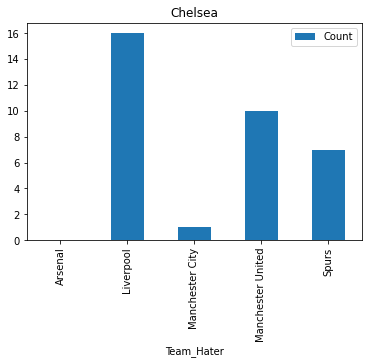

In [193]:
i = ls_sel_tm[1]
print("------------ ทดสอบสัดส่วนความของต่างของคนที่ชอบเชียร์ทีม ->" , i , "------------")
print()
print(f'H0 : แฟนบอลที่เชียร์สโมสร {i} มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 ไม่แตกต่างกัน')
print(f'H1 : แฟนบอลที่เชียร์สโมสร {i} มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 แตกต่างกัน')
print("ที่ระดับนัยสำคัญ 0.05")
print()
data_sel = df_agg_data_adj[df_agg_data_adj["Team_Supporter"] == i]
ls_sell_new = [ij for ij in ls_sel_tm if ij != i]
ls_data_sel = data_sel[data_sel["Team_Supporter"] == i].values[0][1:]
ttsrt = data_sel[data_sel["Team_Supporter"]==i][ls_sell_new].T
ttsrt.columns = ["Count"]
ttsrt = ttsrt.sort_values(by=["Count"],ascending=False)
# ck_len = 5-len(ls_data_sel)
# if len(ls_data_sel) < 5 :
#   for kk in range(ck_len) :
#     ls_data_sel.append(0)
result = chisquare(ls_data_sel)
if result[1] > 0.05 :
  print(f'แฟนบอลสโมสร {i} มีความไม่ชอบต่อสโมสรใน Big6 ไม่แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = {result[1]}')
else :
  print(f'แฟนบอลสโมสร {i} มีความไม่ชอบต่อสโมสรใน Big6 แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = {result[1]}')
  print()
  print(f'>>>>>>>>> ทีมที่แฟนบอลสโมสร {i} ไม่ชอบมากที่สุดคือ {ttsrt.index[0]} <<<<<<<<<<')
print()
toplot = data_sel[ls_sell_new].T.reset_index()
toplot.columns = ["Team_Hater" , "Count"]
toplot.plot.bar(x="Team_Hater",y="Count")
plt.title(i)
plt.savefig(f'/content/drive/MyDrive/BADS7105_CRM_ANALYTICS_AND_INTELLIGENT/HW_09_AB Testing/Overall hate by {i}.png',format='png',dpi=150)
# data_sel.plot.bar(x="Team_Hater",y="Count")

------------ ทดสอบสัดส่วนความของต่างของคนที่ชอบเชียร์ทีม -> Liverpool ------------

H0 : แฟนบอลที่เชียร์สโมสร Liverpool มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 ไม่แตกต่างกัน
H1 : แฟนบอลที่เชียร์สโมสร Liverpool มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 แตกต่างกัน
ที่ระดับนัยสำคัญ 0.05

แฟนบอลสโมสร Liverpool มีความไม่ชอบต่อสโมสรใน Big6 แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = 3.9149319180782143e-28

>>>>>>>>> ทีมที่แฟนบอลสโมสร Liverpool ไม่ชอบมากที่สุดคือ Manchester United <<<<<<<<<<



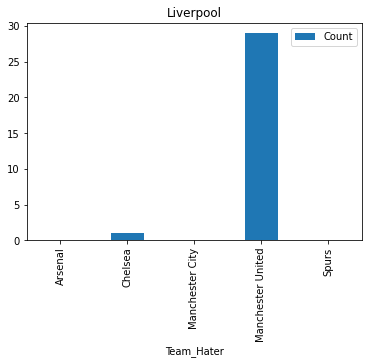

In [194]:
i = ls_sel_tm[2]
print("------------ ทดสอบสัดส่วนความของต่างของคนที่ชอบเชียร์ทีม ->" , i , "------------")
print()
print(f'H0 : แฟนบอลที่เชียร์สโมสร {i} มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 ไม่แตกต่างกัน')
print(f'H1 : แฟนบอลที่เชียร์สโมสร {i} มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 แตกต่างกัน')
print("ที่ระดับนัยสำคัญ 0.05")
print()
data_sel = df_agg_data_adj[df_agg_data_adj["Team_Supporter"] == i]
ls_sell_new = [ij for ij in ls_sel_tm if ij != i]
ls_data_sel = data_sel[data_sel["Team_Supporter"] == i].values[0][1:]
ttsrt = data_sel[data_sel["Team_Supporter"]==i][ls_sell_new].T
ttsrt.columns = ["Count"]
ttsrt = ttsrt.sort_values(by=["Count"],ascending=False)
# ck_len = 5-len(ls_data_sel)
# if len(ls_data_sel) < 5 :
#   for kk in range(ck_len) :
#     ls_data_sel.append(0)
result = chisquare(ls_data_sel)
if result[1] > 0.05 :
  print(f'แฟนบอลสโมสร {i} มีความไม่ชอบต่อสโมสรใน Big6 ไม่แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = {result[1]}')
else :
  print(f'แฟนบอลสโมสร {i} มีความไม่ชอบต่อสโมสรใน Big6 แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = {result[1]}')
  print()
  print(f'>>>>>>>>> ทีมที่แฟนบอลสโมสร {i} ไม่ชอบมากที่สุดคือ {ttsrt.index[0]} <<<<<<<<<<')
print()
toplot = data_sel[ls_sell_new].T.reset_index()
toplot.columns = ["Team_Hater" , "Count"]
toplot.plot.bar(x="Team_Hater",y="Count")
plt.title(i)
plt.savefig(f'/content/drive/MyDrive/BADS7105_CRM_ANALYTICS_AND_INTELLIGENT/HW_09_AB Testing/Overall hate by {i}.png',format='png',dpi=150)
# data_sel.plot.bar(x="Team_Hater",y="Count")

------------ ทดสอบสัดส่วนความของต่างของคนที่ชอบเชียร์ทีม -> Manchester City ------------

H0 : แฟนบอลที่เชียร์สโมสร Manchester City มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 ไม่แตกต่างกัน
H1 : แฟนบอลที่เชียร์สโมสร Manchester City มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 แตกต่างกัน
ที่ระดับนัยสำคัญ 0.05

แฟนบอลสโมสร Manchester City มีความไม่ชอบต่อสโมสรใน Big6 แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = 0.001598917522052272

>>>>>>>>> ทีมที่แฟนบอลสโมสร Manchester City ไม่ชอบมากที่สุดคือ Liverpool <<<<<<<<<<



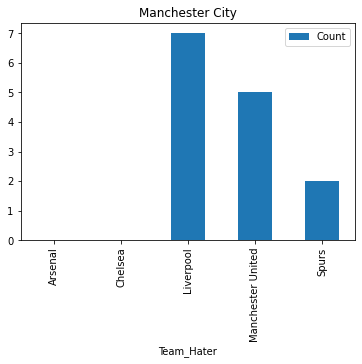

In [195]:
i = ls_sel_tm[3]
print("------------ ทดสอบสัดส่วนความของต่างของคนที่ชอบเชียร์ทีม ->" , i , "------------")
print()
print(f'H0 : แฟนบอลที่เชียร์สโมสร {i} มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 ไม่แตกต่างกัน')
print(f'H1 : แฟนบอลที่เชียร์สโมสร {i} มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 แตกต่างกัน')
print("ที่ระดับนัยสำคัญ 0.05")
print()
data_sel = df_agg_data_adj[df_agg_data_adj["Team_Supporter"] == i]
ls_sell_new = [ij for ij in ls_sel_tm if ij != i]
ls_data_sel = data_sel[data_sel["Team_Supporter"] == i].values[0][1:]
ttsrt = data_sel[data_sel["Team_Supporter"]==i][ls_sell_new].T
ttsrt.columns = ["Count"]
ttsrt = ttsrt.sort_values(by=["Count"],ascending=False)
# ck_len = 5-len(ls_data_sel)
# if len(ls_data_sel) < 5 :
#   for kk in range(ck_len) :
#     ls_data_sel.append(0)
result = chisquare(ls_data_sel)
if result[1] > 0.05 :
  print(f'แฟนบอลสโมสร {i} มีความไม่ชอบต่อสโมสรใน Big6 ไม่แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = {result[1]}')
else :
  print(f'แฟนบอลสโมสร {i} มีความไม่ชอบต่อสโมสรใน Big6 แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = {result[1]}')
  print()
  print(f'>>>>>>>>> ทีมที่แฟนบอลสโมสร {i} ไม่ชอบมากที่สุดคือ {ttsrt.index[0]} <<<<<<<<<<')
print()
toplot = data_sel[ls_sell_new].T.reset_index()
toplot.columns = ["Team_Hater" , "Count"]
toplot.plot.bar(x="Team_Hater",y="Count")
plt.title(i)
plt.savefig(f'/content/drive/MyDrive/BADS7105_CRM_ANALYTICS_AND_INTELLIGENT/HW_09_AB Testing/Overall hate by {i}.png',format='png',dpi=150)
# data_sel.plot.bar(x="Team_Hater",y="Count")

------------ ทดสอบสัดส่วนความของต่างของคนที่ชอบเชียร์ทีม -> Manchester United ------------

H0 : แฟนบอลที่เชียร์สโมสร Manchester United มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 ไม่แตกต่างกัน
H1 : แฟนบอลที่เชียร์สโมสร Manchester United มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 แตกต่างกัน
ที่ระดับนัยสำคัญ 0.05

แฟนบอลสโมสร Manchester United มีความไม่ชอบต่อสโมสรใน Big6 แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = 1.1571590660197325e-45

>>>>>>>>> ทีมที่แฟนบอลสโมสร Manchester United ไม่ชอบมากที่สุดคือ Liverpool <<<<<<<<<<



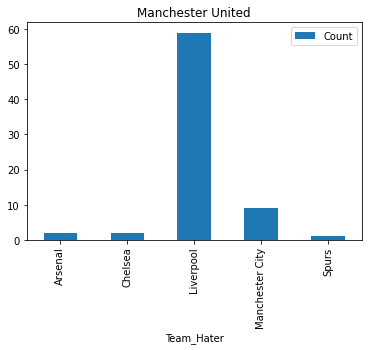

In [196]:
i = ls_sel_tm[4]
print("------------ ทดสอบสัดส่วนความของต่างของคนที่ชอบเชียร์ทีม ->" , i , "------------")
print()
print(f'H0 : แฟนบอลที่เชียร์สโมสร {i} มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 ไม่แตกต่างกัน')
print(f'H1 : แฟนบอลที่เชียร์สโมสร {i} มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 แตกต่างกัน')
print("ที่ระดับนัยสำคัญ 0.05")
print()
data_sel = df_agg_data_adj[df_agg_data_adj["Team_Supporter"] == i]
ls_sell_new = [ij for ij in ls_sel_tm if ij != i]
ls_data_sel = data_sel[data_sel["Team_Supporter"] == i].values[0][1:]
ttsrt = data_sel[data_sel["Team_Supporter"]==i][ls_sell_new].T
ttsrt.columns = ["Count"]
ttsrt = ttsrt.sort_values(by=["Count"],ascending=False)
# ck_len = 5-len(ls_data_sel)
# if len(ls_data_sel) < 5 :
#   for kk in range(ck_len) :
#     ls_data_sel.append(0)
result = chisquare(ls_data_sel)
if result[1] > 0.05 :
  print(f'แฟนบอลสโมสร {i} มีความไม่ชอบต่อสโมสรใน Big6 ไม่แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = {result[1]}')
else :
  print(f'แฟนบอลสโมสร {i} มีความไม่ชอบต่อสโมสรใน Big6 แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = {result[1]}')
  print()
  print(f'>>>>>>>>> ทีมที่แฟนบอลสโมสร {i} ไม่ชอบมากที่สุดคือ {ttsrt.index[0]} <<<<<<<<<<')
print()
toplot = data_sel[ls_sell_new].T.reset_index()
toplot.columns = ["Team_Hater" , "Count"]
toplot.plot.bar(x="Team_Hater",y="Count")
plt.title(i)
plt.savefig(f'/content/drive/MyDrive/BADS7105_CRM_ANALYTICS_AND_INTELLIGENT/HW_09_AB Testing/Overall hate by {i}.png',format='png',dpi=150)
# data_sel.plot.bar(x="Team_Hater",y="Count")

------------ ทดสอบสัดส่วนความของต่างของคนที่ชอบเชียร์ทีม -> Spurs ------------

H0 : แฟนบอลที่เชียร์สโมสร Spurs มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 ไม่แตกต่างกัน
H1 : แฟนบอลที่เชียร์สโมสร Spurs มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 แตกต่างกัน
ที่ระดับนัยสำคัญ 0.05

แฟนบอลสโมสร Spurs มีความไม่ชอบต่อสโมสรใน Big6 ไม่แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = 0.17558838731303802



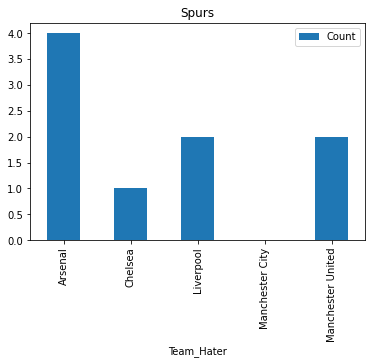

In [197]:
i = ls_sel_tm[5]
print("------------ ทดสอบสัดส่วนความของต่างของคนที่ชอบเชียร์ทีม ->" , i , "------------")
print()
print(f'H0 : แฟนบอลที่เชียร์สโมสร {i} มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 ไม่แตกต่างกัน')
print(f'H1 : แฟนบอลที่เชียร์สโมสร {i} มีสัดส่วนในความไม่ชอบทีมอื่นๆใน Big6 แตกต่างกัน')
print("ที่ระดับนัยสำคัญ 0.05")
print()
data_sel = df_agg_data_adj[df_agg_data_adj["Team_Supporter"] == i]
ls_sell_new = [ij for ij in ls_sel_tm if ij != i]
ls_data_sel = data_sel[data_sel["Team_Supporter"] == i].values[0][1:]
ttsrt = data_sel[data_sel["Team_Supporter"]==i][ls_sell_new].T
ttsrt.columns = ["Count"]
ttsrt = ttsrt.sort_values(by=["Count"],ascending=False)
# ck_len = 5-len(ls_data_sel)
# if len(ls_data_sel) < 5 :
#   for kk in range(ck_len) :
#     ls_data_sel.append(0)
result = chisquare(ls_data_sel)
if result[1] > 0.05 :
  print(f'แฟนบอลสโมสร {i} มีความไม่ชอบต่อสโมสรใน Big6 ไม่แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = {result[1]}')
else :
  print(f'แฟนบอลสโมสร {i} มีความไม่ชอบต่อสโมสรใน Big6 แตกต่างกันอย่างมีนัยสำคัญ โดยมีค่า P-Value = {result[1]}')
  print()
  print(f'>>>>>>>>> ทีมที่แฟนบอลสโมสร {i} ไม่ชอบมากที่สุดคือ {ttsrt.index[0]} <<<<<<<<<<')
print()
toplot = data_sel[ls_sell_new].T.reset_index()
toplot.columns = ["Team_Hater" , "Count"]
toplot.plot.bar(x="Team_Hater",y="Count")
plt.title(i)
plt.savefig(f'/content/drive/MyDrive/BADS7105_CRM_ANALYTICS_AND_INTELLIGENT/HW_09_AB Testing/Overall hate by {i}.png',format='png',dpi=150)
# data_sel.plot.bar(x="Team_Hater",y="Count")